# ROB2004 Final Project - pick and place objects

The goal of this project is to solve a simple manipulation task: picking up objects and moving them in a bowl.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.
* This is an individual project

We will use a model of the Frank-Emika Panda robot. This robot has 7 revolute joints and its kinematics is described in the picture below.

You will need to install pybullet on your computer. Please reach out as soon as possible for help if you do not know how to do it.

<div>
<img src="./panda.jpg" width="200"/>
</div>

# Question

Implement a controller using the code skeletong below in order to get the robot to go and pick up the red blocks and drop them in the green bowl. The bowl position is $(-0.3,0.55,0.65)$ (in spatial frame coordinates) and the blocks positions are $(0.35,0.58,0.65)$ and $(0.15,0.67,0.65)$ respectively.

<div>
<img src="./manipulation_scene.jpg" width="300"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy and scipy
* You need to use at least one controller in the end-effector space
* You need to generate smooth motions
* You need to compensate for the gravity of the robot

In your report, describe the controller and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit).

In [9]:
import numpy as np
import time

import matplotlib.pyplot as plt

from panda import Simulator, PandaRobot

np.set_printoptions(precision=4, suppress = True)

# Helper functions

We provide a set of helper functions (forward kinematics, Jacobians, gravity terms) that can be used to implement the desired controllers. These functions are implemented in the PandaRobot class (in the panda.py file).
Examples are shown below:

In [10]:
# create an instance of the helper class
my_robot = PandaRobot()

# compute the forward kinematics for an arbitrary joint configuration
q = np.random.uniform(-1,1,7)
pose = my_robot.FK(np.array([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0]))
print(f'the pose of the end-effector for joint configuration\n\n {q}\n\n is\n\n {pose}')

the pose of the end-effector for joint configuration

 [-0.3407  0.2473  0.5945 -0.1661 -0.876  -0.933   0.0597]

 is

 [[-0.7071  0.7071  0.      0.    ]
 [ 0.7071  0.7071 -0.      0.5545]
 [-0.      0.     -1.      0.6245]
 [ 0.      0.      0.      1.    ]]


In [3]:
# we can also get the Jacobian in various frames 
# it is sufficient to pass the name of the frame as an argument as shown below

q = np.random.uniform(-1,1,7)

spatial_jacobian = my_robot.get_jacobian(q, 'S')
body_jacobian = my_robot.get_jacobian(q, 'B')

# we can even get the Jacobian in a frame place at the same position as the end-effector 
# frame but oriented like the spatial frame
oriented_jacobian = my_robot.get_jacobian(q, 'O')

print(f'for joint configuration \n\n {q} \n \n the spatial Jacobian is \n\n {spatial_jacobian}\n\n')
print(f'the body Jacobian is \n\n {body_jacobian}\n\n')
print(f'and the Jacobian in a frame placed at the same position as the end-effector but oriented like the spatial frame is\n\n {oriented_jacobian}')

for joint configuration 

 [ 0.7298 -0.1443 -0.5202  0.7988 -0.8611  0.3669 -0.1614] 
 
 the spatial Jacobian is 

 [[ 0.     -0.7453  0.0959  0.9747  0.2117  0.6899  0.0507]
 [ 0.     -0.6667 -0.1071  0.212  -0.7708 -0.3176  0.9176]
 [ 1.      0.      0.9896 -0.0715  0.6009 -0.6505 -0.3943]
 [ 0.      0.222   0.0357 -0.1424  0.453   0.4554 -0.6961]
 [ 0.     -0.2482  0.0319  0.6404  0.1132  0.6321  0.1093]
 [ 0.      0.     -0.     -0.0422 -0.0144  0.1744  0.165 ]]


the body Jacobian is 

 [[ 0.9072 -0.1621  0.8419 -0.1151  0.2096 -0.8116 -0.    ]
 [ 0.1468 -0.7428  0.2392  0.9554  0.2911  0.5843  0.    ]
 [-0.3943 -0.6496 -0.4837  0.2721 -0.9335  0.      1.    ]
 [ 0.0426  0.4198  0.0313 -0.3074  0.0978  0.0625 -0.    ]
 [ 0.1795 -0.2922  0.1241 -0.0171 -0.0704  0.0868 -0.    ]
 [ 0.165   0.2294  0.1159 -0.0701 -0.     -0.088  -0.    ]]


and the Jacobian in a frame placed at the same position as the end-effector but oriented like the spatial frame is

 [[ 0.     -0.7453  0.0959  0.

In [4]:
# finally it is possible to compute the effect of gravity on the joints
# this can for example be used to do gravity compensation when controlling the robot

q = np.random.uniform(-1,1,7)

g = my_robot.g(q)

print(f'for joint configuration \n\n {q} \n \n the gravity force seen on the joints is \n \n {g}')

for joint configuration 

 [ 0.9577 -0.9869 -0.7846 -0.7028 -0.1918 -0.7533 -0.7655] 
 
 the gravity force seen on the joints is 
 
 [-0.     37.8666 10.2762 -5.8364  0.1332  0.1554  0.    ]


# Code Skeleton for the simulation

Feel free to change the `run_time` variable to match your needs. The class `Simulator` contains all the code for the simulation. The code skeleton currently implement a simple PD controller in joint space that just keeps a desired current position.

Importantly you can control both the joints and the gripper of the robot:
* `simulator.send_joint_torque(joint_torques)` sends a vector of dimension 7 setting the torques of the joints
* `simulator.gripper_move(gripper_position)` sends a vector of dimension 2 setting the position of the fingers of the gripper. The fingers can have positions from 0 to 0.04cm (you can fully close the gripper by setting `simulator.gripper_move([0,0])` and fully open it by setting `simulator.gripper_move([0.04,0.04)`)

In [5]:
#---------- USER CODE --------------#
# import numpy pseudo inverse function
from numpy.linalg import pinv
# import numpy single value decomposition
from numpy.linalg import svd

# Compute desire trajectory, returns desired position and desired velocity
def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    desired_position = 0
    desired_velocity = 0
    T = t_goal - t_init # compute difference between final time and initial
    
    # Use a 5th order polynomial to compute the desired position and velocity at end-effector space
    desired_position = position_init + ((10 / np.power(T, 3)) * np.power(t - t_init, 3) + (-15 / np.power(T, 4)) * np.power(t - t_init, 4) + (6 / np.power(T, 5)) * np.power(t - t_init, 5)) * (position_goal - position_init)
    desired_velocity = ((30 / np.power(T, 3)) * np.power(t - t_init, 2) + (-60 / np.power(T, 4)) * np.power(t - t_init, 3) + (30 / np.power(T, 5)) * np.power(t - t_init, 4)) * (position_goal - position_init)

    return desired_position, desired_velocity

# Inverse jacobain 
# Avoid the problem of singularity using the damping least square method
#  - A damp factor is added to the diagonal of the Jacobian matrix to regularize it and avoid singularities 
#  - The damped least squares method returns a unique and optimal solution that minimizes the error between 
#    the actual and desired end-effector positions or velocities.
def inverse_jacobian(J, damping_coefficient=0.1):
    
    singularity_value = svd(J, compute_uv=False)
    
    # check singularity
    if min(singularity_value) < 1e-6:
        # add damping factor 
        J_damped = J + damping_coefficient*np.eye(J.shape[1])
        J_inv = np.linalg.inv(J)
    else:
        # compute the pseudo inverse of the jacobian
        J_inv = np.linalg.pinv(J)
    
    return J_inv
    
def pseudo_inverse(J):
    J_pseudo_inverse = pinv(J)
    
    return J_pseudo_inverse
    

#-----------------------------------#

In [6]:
# RUNTIME AT 30 seconds !!!!!!!!!!

# here we create a simulation and reset the state of the robot
simulator = Simulator()
simulator.reset_state([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0])

# we create a robot object so we can use its helper functions
my_robot = PandaRobot()

# duration of the simulation
run_time = 31.

# simulation time step
dt = 0.005
num_steps = int(run_time/dt)


# we store information
ndofs = 7 # number of degrees of freedom (excluding the gripper)
measured_positions = np.zeros([num_steps,ndofs])
measured_velocities = np.zeros_like(measured_positions)
measured_finger_position = np.zeros([num_steps,3])
desired_finger_position = np.zeros([num_steps,3])

desired_torques = np.zeros_like(measured_positions)
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
time = np.zeros([num_steps])

#---------- USER CODE --------------#
# Blocks and bowl position
bowl_position = np.array([-0.3, 0.55, 0.65])
block1_position_1 = np.array([0.35, 0.58, 0.45])
block1_position_2 = np.array([0.35, 0.58, 0.30])
block2_position_1 = np.array([0.15, 0.67, 0.45])
block2_position_2 = np.array([0.15, 0.67, 0.30])

# Gripper initial state
gripper_position = [0.0, 0.0]

# Store initial state of the robot
q0, dq0 = simulator.get_state() 

# Initial pose
initial_pose = my_robot.FK(q0)

#-----------------------------------#


### this is the main control loop
for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we get the position and velocities of the joints
    q, dq = simulator.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    ## controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO SOLVE THE TASK
    ## you will need to replace the naive PD controller implemented below
    
    #---------- USER CODE --------------#
    # the PD gains
    P = np.array([30, 30, 30])
    D = np.array([0.012, 0.012, 0.012])

    # Current robot pose
    pose = my_robot.FK(q)
    # Current finger position
    current_finger_position = pose[0:3,3]
    measured_finger_position[i,:] = pose[0:3,3]

    # BLOCK 1 OPERATION
    # Move from the starting position to a position above block1 
    if 0 <= time[i] < 3: 
        start_pos = initial_pose[0:3,3]
        end_goal = block1_position_1
        t_init = 0
        t_final = 3
        
        x_ref, x_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])
        x_dot_des = x_dot_ref + P * (x_ref - current_finger_position)
        
    
    # Descend from the top down to where block1 is to pick up the block
    elif 3 <= time[i] < 6: 
        start_pos = block1_position_1
        end_goal = block1_position_2
        t_init = 3
        t_final = 6
        
        x_ref, x_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])
        x_dot_des = x_dot_ref + P * (x_ref - current_finger_position)
    
    # Ascend back up
    elif 7 <= time[i] < 10:
        start_pos = block1_position_2
        end_goal = block1_position_1
        t_init = 7
        t_final = 10
        
        x_ref, x_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])
        x_dot_des = x_dot_ref + P * (x_ref - current_finger_position)
        
    # Move from block1 to a position above the bowl
    elif 10 <= time[i] < 13:
        start_pos = block1_position_1
        end_goal = bowl_position
        t_init = 10
        t_final = 13
        
        x_ref, x_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])
        x_dot_des = x_dot_ref + P * (x_ref - current_finger_position)
        
        
    # BLOCK 2 OPERATION
    # Move from the bowl to a position above block2
    elif 14 <= time[i] < 17:
        start_pos = bowl_position
        end_goal = block2_position_1
        t_init = 14
        t_final = 17
        
        x_ref, x_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])
        x_dot_des = x_dot_ref + P * (x_ref - current_finger_position)
        
    # Descend down to block2 to pick up the block
    elif 17 <= time[i] < 20:
        start_pos = block2_position_1
        end_goal = block2_position_2
        t_init = 17
        t_final = 20
        
        x_ref, x_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])
        x_dot_des = x_dot_ref + P * (x_ref - current_finger_position)
        
    # Ascend back up
    elif 21 <= time[i] < 24:
        start_pos = block2_position_2
        end_goal = block2_position_1
        t_init = 21
        t_final = 24
        
        x_ref, x_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])
        x_dot_des = x_dot_ref + P * (x_ref - current_finger_position)
    
    # Move from above block 2 to above bowl position
    elif 24 <= time[i] < 27:
        start_pos = block2_position_1
        end_goal = bowl_position
        t_init = 24
        t_final = 27
        
        x_ref, x_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])
        x_dot_des = x_dot_ref + P * (x_ref - current_finger_position)
    
    # GRIPPER OPERATION
    # Drop the block into the bowl by opening the gripper
    if 2 <= time[i] < 3 or 13 <= time[i] < 14 or 27 <= time[i] < 28:
        gripper_position = [0.04, 0.04]
        
    # Grab the block by closing the gripper
    elif 6 <= time[i] < 7 or 20 <= time[i] < 21:
        gripper_position = [0.0, 0.0]
        
#     print("x_ref:", x_ref)
#     print("x_dot_ref:", x_dot_ref)
#     print("x_dot_des:", x_dot_des)
#     print("P", P)
#     print("current_finger_position:", current_finger_position)
    
    # Compute desired joint velocity using inverse jacobian and end effector velocity
    J = my_robot.get_jacobian(q, 'O') # returs 6 by 3
    J_linear = J[3:,:] # gets by 3 by 3
    J_inverse = inverse_jacobian(J_linear) # take inverse jacobian 
    dq_des = J_inverse @ x_dot_des # compute desired joint velocity
    
    # Fix the robot's position
    if 13 <= time[i] < 14 or time[i] >= 27:
        dq_des = np.zeros([7])
    #-----------------------------------#

    # desired joint positions and velocities
#     q_des = np.array([0.0,0.0,1,-np.pi/2.,0.0,np.pi/2,0.0])
#     dq_des = np.zeros([7])
    
    # we save the desired positions/velocities for later plotting 
#     desired_positions[i,:] = q_des
    desired_velocities[i,:] = dq_des
    
    ##PD controller
    # the PD gains
    P = np.array([100., 100., 100., 100., 100., 100., 50.])
    D = np.array([10.,10,10,10,10,10,1.])

#     error = q_des - q # the position error for all the joints
    d_error = dq_des-dq # the velocity error for all the joints
    
    
    # we compute the desired torques as a PD controller
#     joint_torques = np.diag(P) @ error + np.diag(D) @ d_error + my_robot.g(q)
    joint_torques = np.diag(D) @ d_error + my_robot.g(q)
    
    # we start by closing the gripper and then open it after 5 seconds
#     gripper_position = [0.04,0.04]
#     if time[i] > 5.0:
#         gripper_position = [0.04, 0.04]
    
    # we send them to the robot and do one simulation step
    simulator.send_joint_torque(joint_torques)
    simulator.gripper_move(gripper_position)
    simulator.step()

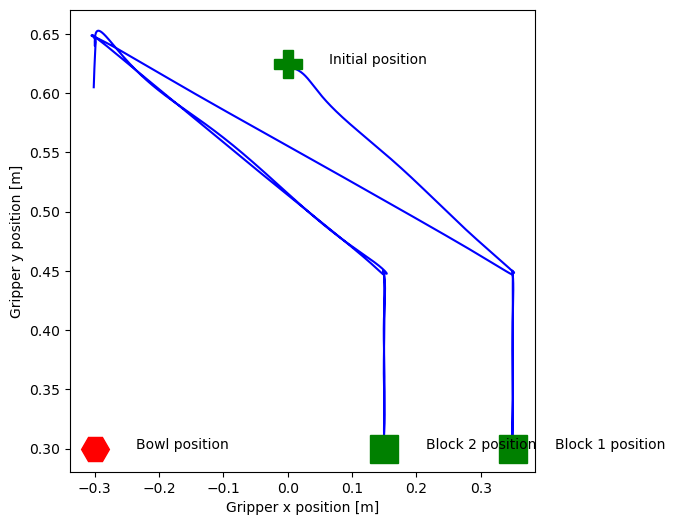

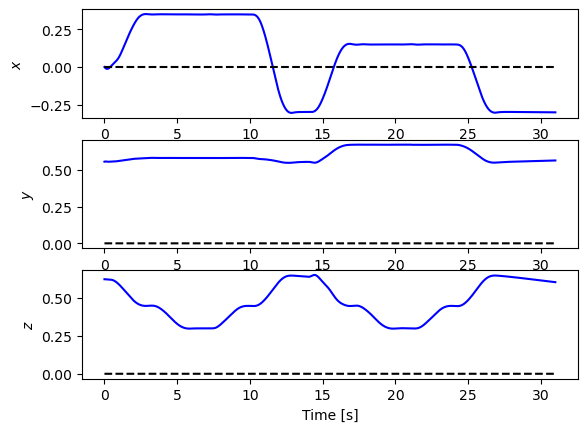

In [7]:
def plot_finger_trajectory(finger_position):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,0],finger_position[:,2], 'b')
    plt.xlabel('Gripper x position [m]')
    plt.ylabel('Gripper y position [m]')
#     plt.xlim([-0.4, 0.8])
#     plt.ylim([-0.9,-0.3])
    
#     plt.plot([0],[0],'o',markersize=15,color='r')
    
#     for ball in ball_positions:
#         plt.plot([ball[0]],[ball[1]],'o',markersize=15,color='g')
#         ax.annotate('Goal position', xy=(ball[0]-0.2,0.05+ball[1]), xytext=(30,0), textcoords='offset points')
#     ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    
    
    # Print initial position 
    initial_position = initial_pose[0:3,3]
    plt.plot([initial_position[0]],[initial_position[2]],'P',markersize=20,color='g')
    ax.annotate('Initial position', xy=(initial_position[0], initial_position[2]), xytext=(30,0), textcoords='offset points')
    # Print block 1 location
    plt.plot([block1_position_2[0]],[block1_position_2[2]],'s',markersize=20,color='g')
    ax.annotate('Block 1 position', xy=(block1_position_2[0], block2_position_2[2]), xytext=(30,0), textcoords='offset points')
    # Print block 2 location
    plt.plot([block2_position_2[0]],[block2_position_2[2]],'s',markersize=20,color='g')
    ax.annotate('Block 2 position', xy=(block2_position_2[0], block1_position_2[2]), xytext=(30,0), textcoords='offset points')
    # Print bowl location
    plt.plot([bowl_position[0]],[block2_position_2[2]],'H',markersize=20,color='r')
    ax.annotate('Bowl position', xy=(bowl_position[0], block2_position_2[2]), xytext=(30,0), textcoords='offset points')
    
    fig = plt.figure()
    
    plt.subplot(3,1,1)
    plt.plot(time, measured_finger_position[:,0], 'b-', time, desired_finger_position[:,0], '--k')
    plt.ylabel(r'$x$')
    plt.subplot(3,1,2)
    plt.plot(time, measured_finger_position[:,1], 'b-', time, desired_finger_position[:,1], '--k')
    plt.ylabel(r'$y$')
    plt.subplot(3,1,3)
    plt.plot(time, measured_finger_position[:,2], 'b-', time, desired_finger_position[:,2], '--k')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')

plot_finger_trajectory(measured_finger_position)

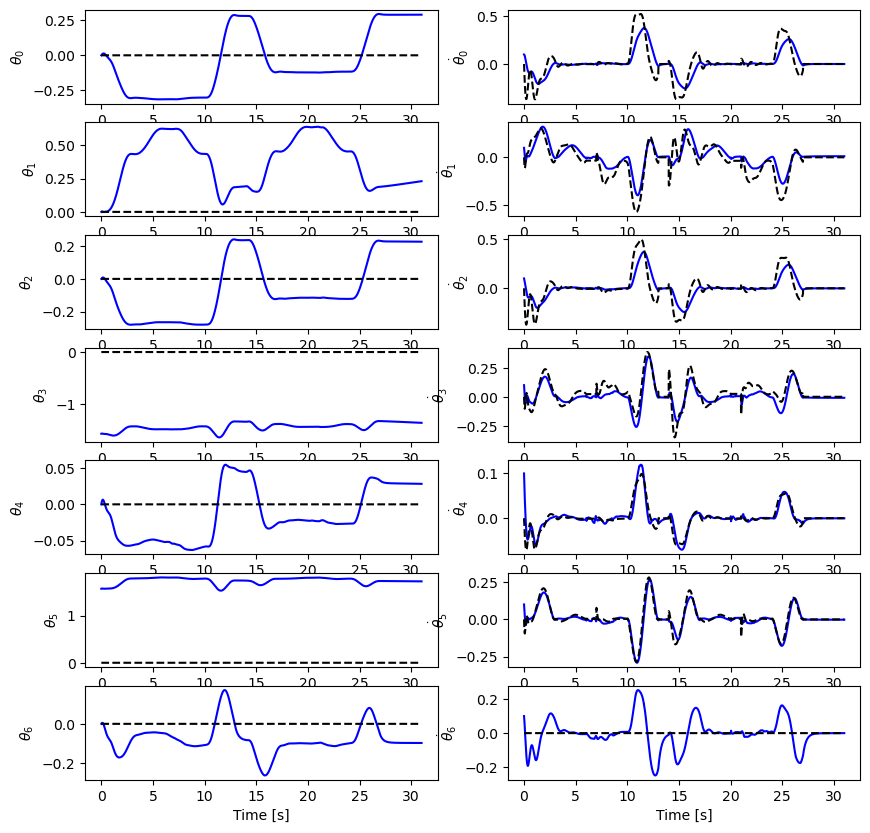

In [8]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))

    # Joint 1 Position
    plt.subplot(7,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'$\theta_0$')
    
    # Joint 2 Position
    plt.subplot(7,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_1$')
    
    # Joint 3 Position
    plt.subplot(7,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$\theta_2$')
    plt.xlabel('Time [s]')
    
    # Joint 4 Position
    plt.subplot(7,2,7)
    plt.plot(time, th[:,3], 'b-', time, th_des[:,3], '--k')
    plt.ylabel(r'$\theta_3$')
    plt.xlabel('Time [s]')
    
    # Joint 5 Position
    plt.subplot(7,2,9)
    plt.plot(time, th[:,4], 'b-', time, th_des[:,4], '--k')
    plt.ylabel(r'$\theta_4$')
    plt.xlabel('Time [s]')
    
    # Joint 6 Position
    plt.subplot(7,2,11)
    plt.plot(time, th[:,5], 'b-', time, th_des[:,5], '--k')
    plt.ylabel(r'$\theta_5$')
    plt.xlabel('Time [s]')
    
    # Joint 7 Position
    plt.subplot(7,2,13)
    plt.plot(time, th[:,6], 'b-', time, th_des[:,6], '--k')
    plt.ylabel(r'$\theta_6$')
    plt.xlabel('Time [s]')
    
    
    # Joint 1 Velocity 
    plt.subplot(7,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'$\dot{\theta}_0$')
    
    # Joint 2 Velocity 
    plt.subplot(7,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_1$')
    
    # Joint 3 Velocity 
    plt.subplot(7,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{\theta}_2$')
    plt.xlabel('Time [s]')
    
    # Joint 4 Velocity 
    plt.subplot(7,2,8)
    plt.plot(time, dth[:,3], 'b-', time, dth_des[:,3], '--k')
    plt.ylabel(r'$\dot{\theta}_3$')
    plt.xlabel('Time [s]')
    
    # Joint 5 Velocity 
    plt.subplot(7,2,10)
    plt.plot(time, dth[:,4], 'b-', time, dth_des[:,4], '--k')
    plt.ylabel(r'$\dot{\theta}_4$')
    plt.xlabel('Time [s]')
    
    # Joint 6 Velocity 
    plt.subplot(7,2,12)
    plt.plot(time, dth[:,5], 'b-', time, dth_des[:,5], '--k')
    plt.ylabel(r'$\dot{\theta}_5$')
    plt.xlabel('Time [s]')
    
    # Joint 7 Velocity 
    plt.subplot(7,2,14)
    plt.plot(time, dth[:,6], 'b-', time, dth_des[:,6], '--k')
    plt.ylabel(r'$\dot{\theta}_6$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_positions, desired_positions, measured_velocities, desired_velocities)